In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Object Detection Project
## Machine Learing & Deep Learning, WS23

### 1. Introduction
The following project is a part of the course ML & DL at the Klagenfurt Universität.

The goal of this project is to detect football players, the ball, referees and goalkeepers on the field.
This is done using pretrained models and transfer learning. 
Different yoloversion as well as DETR.
https://www.kaggle.com/code/filipkjellgren/footballproject/edit


### 2. Data Preprocessing
Can be found in attachde files. Was completed on a local machine.


#### 2.1 Helper functions

In [2]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def draw_boxes(image_path, labels_path, ax=None):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load YOLOv5 labels
    with open(labels_path, 'r') as file:
        lines = file.readlines()

    #defining my color map for the boxes
    colors = plt.cm.get_cmap('tab10', 4)
   
    for line in lines:
        # Example YOLOv5 label format: "class x_center y_center width height"
        data = line.split()
        class_id = int(data[0])
        x_center, y_center, width, height = map(float, data[1:])

        # Convert YOLO coordinates to image coordinates
        image_width, image_height = image.shape[1], image.shape[0]
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        x_max = int((x_center + width / 2) * image_width)
        y_max = int((y_center + height / 2) * image_height)

        # Get color for the current class
        color = np.array(colors(class_id)[:3]) * 255

        # Draw bounding box on the image with a unique color for each class
        thickness = 2
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

    if ax is None:
        # Display the image in the Jupyter Notebook
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        # Display the image on the provided Axes object
        ax.imshow(image)
        ax.axis('off')
        


/tmp/ipykernel_34/2720470696.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


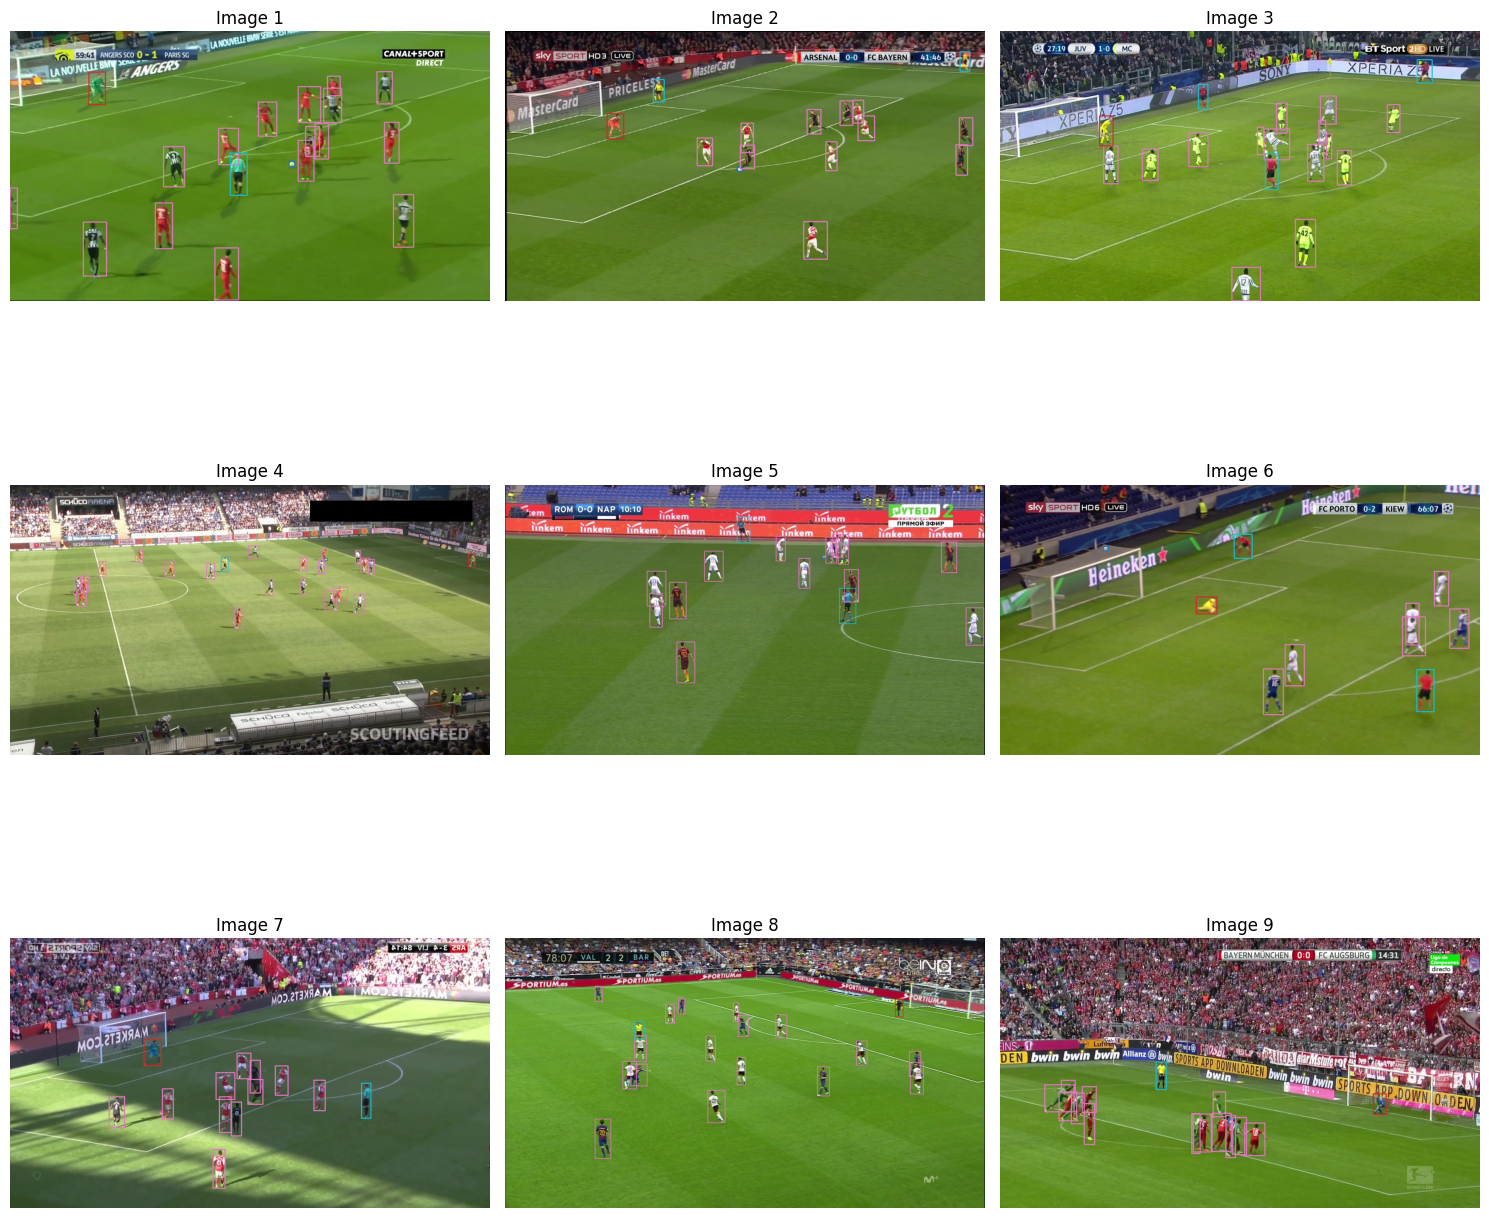

In [3]:
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Function to load 9 different image paths and label paths
def load_random_paths(images_folder, labels_folder, num_images):
    image_files = os.listdir(images_folder)
    label_files = os.listdir(labels_folder)
    random_images = random.sample(image_files, num_images)
    random_labels = [Path(lbl).with_suffix('.txt').name for lbl in random_images]  # Ensure only extension is changed
    return [os.path.join(images_folder, img) for img in random_images], [os.path.join(labels_folder, lbl) for lbl in random_labels]

# Loop to plot 9 images with bounding boxes in a 3x3 grid
num_images = 9
images_folder = '/kaggle/input/footballdataset2/final_dataset_evo_v3/train/images'
labels_folder = '/kaggle/input/footballdataset2/final_dataset_evo_v3/train/labels'
image_paths, label_paths = load_random_paths(images_folder, labels_folder, num_images)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
    ax = axes[i // 3, i % 3]  # Calculate subplot index
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
    draw_boxes(image_path, label_path, ax)

plt.tight_layout()
plt.show()


### 3. Config

In [18]:
config = {
    'model':'yolov8',
    'epochs': 15,
    'freeze': True,
    'num_freeze_layers': 10,
    'batch_size': 32,
    'optimizer':'SGD',
    'learning_rate':0.0125,
    'img_size':640,
    'momentum':0.937,
    'experiment_name':"v8_run",
    'project_name': 'footballDetection',
    'patience':50,
    'only_ball': False,
    'use_only_ball_weights': False,
    'augment': True
}

augmentations_conf ={
    'mosaic': 0.0,
    'scale':0.0,
    'hsv_h':0.0,
    'hsv_s':0.0,
    'hsv_v':0.0,
    'degree': 0.0,
    'translate':0.0,
    'fliplr':0.0,
    'erasing':0.0
}

In [5]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Make changes to the YAML file if necessary
If changes were made to the dataset, or names, or file paths.
Had to update the data.yaml file for some datasets

In [6]:
import yaml

# Specify the path to your YAML file
yaml_file_path = '/kaggle/input/yaml-file/data.yaml'
new_yaml_file_path = '/kaggle/working/data.yaml'
# Read the YAML file
with open(yaml_file_path, 'r') as file:
    config_data = yaml.safe_load(file)

# Modify the paths in the config data
config_data['train'] = config_data['train'].replace('footballDataset1/final_dataset_evo_v3', 'footballdataset2/final_dataset_evo_v3')
config_data['val'] = config_data['val'].replace('footballDataset1/final_dataset_evo_v3', 'footballdataset2/final_dataset_evo_v3')
config_data['test'] = config_data['test'].replace('footballDataset1/final_dataset_evo_v3', 'footballdataset2/final_dataset_evo_v3')

# Write the updated config data back to the YAML file
with open(new_yaml_file_path, 'w') as file:
    yaml.dump(config_data, file)

# Modify the HyperParameters that are passed to train.py
These hyperparameters and augmentations setting will override all the above configs (if they are for the same parameter).
Used for different cases  in the project process.

In [7]:
def write_yaml(data, filename):
    with open(filename, 'w') as file:
        yaml.dump(data, file)

# Example data
data = {
    'lr0': 0.01,             #initial learning rate
    'lrf': 0.1,              #final learning rate
    'momentum': 0.937,       #momentum value for optimization
    'weight_decay': 0.0005,  #weight decay parameter (L2 regularization)
    'warmup_epochs': 3.0,    #number of epochs for learning rate warm-up
    'warmup_momentum': 0.8,  #momentum value during warm-up
    'warmup_bias_lr': 0.1,   #learning rate for bias parameters during warm-up
    'box': 0.05,             #weight for bounding box loss
    'cls': 0.3,              #weight for class loss
    'kobj': 1.0,             #coefficient for objectness loss
    'iou': 0.40,             #intersection over Union (IoU) threshold
    'hsv_h': 0,              #hue parameter for HSV color space augmentation
    'hsv_s': 0,              #saturation parameter for HSV color space augmentation
    'hsv_v': 0,              #value parameter for HSV color space augmentation
    'degrees': 0.0,          #range degrees for rotation augmentation
    'translate': 0,          #range pixels for translation augmentation
    'scale': 0,              #range of scale factors for scaling augmentation
    'shear': 0,              #range of shear angles for shearing augmentation
    'perspective': 0.0,      #range of perspective distortion for perspective transformation augmentation
    'flipud': 0.0,           #probability of flipping images verticallys
    'fliplr': 0.3,           #probability of flipping images horizontally
    'mosaic': 0.0,           #probability of using mosaic augmentation
    'mixup': 0.0,            #probability of using mixup augmentation
    'copy_paste': 0.0        #probability of using copy-paste augmentation
}



write_yaml(data, '/kaggle/working/config.yaml')


### 4.Imports

In [8]:
#clone YOLOv5 and
!pip install wandb
!pip install ultralytics
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
from ultralytics import YOLO
from ultralytics import RTDETR
from IPython.display import Image, clear_output  # to display images
import torch

import wandb

from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 10.5 MB/s eta 0:00:00a 0:00:01
Cloning into 'yolov5'...
remote: Enumerating objects: 16491, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16491 (delta 27), reused 35 (delta 9), pack-reused 16408
Receiving objects: 100% (16491/16491), 15.11 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (11292/11292), done.
/kaggle/working/yolov5
Setup complete. Using torch 2.1.2 (Tesla P100-PCIE-16GB)


### 5. Training

Ultralytics YOLO-training configuration is directly connected to weights and biases.
Importatnt Metrics Logged: clc_loss, box_loss, giou_loss, mAP(50/50-95), precision, recall.

WANDB LOGS : https://wandb.ai/fikjellgren/footballDetection

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
    print("CUDA available, using GPU for computation")
else:
    device = 'cpu'
    print("CUDA not available, using CPU for computation.")

CUDA available, using GPU for computation


In [19]:
if(config['model'] == 'yolov5'):
    print("TRAINING YOLOv5")        
    model = YOLO(model='yolov5m.pt')
elif(config['model'] == 'yolov8'):
    if(config['use_only_ball_weights']):
        model = YOLO('/kaggle/working/yolov5/footballDetection/v8_ball_1280/weights/best.pt')
        print("Using onlyBall weights")
    else: 
        model = YOLO('yolov8m.pt')
    print("TRAINING YOLOv8")
elif(config['model'] == 'yoloDETR'):
    print("TRAINING DEtR")
    if(config['use_only_ball_weights']):
        model = RTDETR('/kaggle/input/ballweightsdetr/best.pt')
        print("Using onlyBall weights")
    else: 
        model = RTDETR('rtdetr-l.pt')    
else:
    print("NO MODEL WAS CHOOSEN")
model.info()
model.to(device)
if (config['only_ball']):
    results = model.train(data='/kaggle/input/balldataset1/ball_detection_set/data.yaml',cfg='/kaggle/working/config.yaml',augment=config['augment'],patience=config['patience'], project=config['project_name'],name=config['experiment_name'] ,epochs=config["epochs"], imgsz=config['img_size'], freeze= config['num_freeze_layers'] if config['freeze'] else None, batch=config['batch_size'], optimizer=config['optimizer'])
    print("Training on only-ball dataset")
else:      
    results = model.train(data='/kaggle/working/data.yaml',cfg='/kaggle/working/config.yaml',augment=config['augment'],mosaic=0.0,patience=config['patience'], project=config['project_name'],name=config['experiment_name'] ,epochs=config["epochs"], imgsz=config['img_size'], freeze= config['num_freeze_layers'] if config['freeze'] else None, batch=config['batch_size'], optimizer=config['optimizer'])
    print("Training on the full dataset")

Using onlyBall weights
TRAINING YOLOv8
Model summary: 295 layers, 25856899 parameters, 0 gradients, 79.1 GFLOPs
Ultralytics YOLOv8.1.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=None, data=/kaggle/working/data.yaml, epochs=15, time=None, patience=50, batch=-1, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=footballDetection, name=v8_ball_1280_24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.2.m.1.cv1.conv.weight'
Freezing layer 'model.2.m.1.cv1.bn.weight'
Freezing layer 'model.2.m.1.cv1.bn.bias'
Freezing layer 'model.2.m.1.cv2.conv.weight'
Freezing layer 'model.2.m.1.cv2.bn.weight'
Freezing layer 'model.2.m.1.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Fre

train: Scanning /kaggle/input/footballdataset2/final_dataset_evo_v3/train/labels... 3956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3956/3956 [00:34<00:00, 114.87it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/footballdataset2/final_dataset_evo_v3/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/footballdataset2/final_dataset_evo_v3/val/labels... 1101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1101/1101 [00:09<00:00, 111.36it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/footballdataset2/final_dataset_evo_v3/val is not writeable, cache not saved.
Plotting labels to footballDetection/v8_ball_1280_24/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to footballDetection/v8_ball_1280_24
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      12.7G     0.0115      1.078      1.563         53       1280: 100%|██████████| 248/248 [05:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.804      0.712      0.771      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      14.2G   0.006564       0.39      1.113         45       1280: 100%|██████████| 248/248 [05:13<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]

                   all       1101      16643      0.843      0.811      0.855      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      14.3G   0.006185     0.3272      1.078         61       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]

                   all       1101      16643      0.879      0.845      0.884      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      15.7G   0.005996     0.2985       1.06         74       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.883      0.852       0.89      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      15.7G   0.005838     0.2795      1.048         66       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]

                   all       1101      16643      0.893      0.855      0.894      0.621


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      14.3G   0.005701      0.267      1.033         88       1280: 100%|██████████| 248/248 [05:16<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]

                   all       1101      16643      0.884      0.874      0.898      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      14.3G   0.005583     0.2543      1.022         54       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.906      0.864      0.897      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      14.3G   0.005422     0.2446      1.008         60       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.898      0.874      0.904      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      14.3G   0.005278     0.2336     0.9946         69       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]

                   all       1101      16643      0.916      0.875      0.907      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      14.3G   0.005138     0.2254     0.9818         82       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.922      0.892      0.921      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      14.3G   0.004977     0.2169     0.9686         64       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]

                   all       1101      16643      0.927       0.89      0.924      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      14.3G   0.004846     0.2099     0.9564         68       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.927      0.898       0.93      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      14.3G   0.004725     0.2035     0.9455         72       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.927      0.907      0.934      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      15.7G   0.004569     0.1981     0.9324         60       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]

                   all       1101      16643      0.933      0.909      0.935      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      14.3G    0.00443     0.1922     0.9219         63       1280: 100%|██████████| 248/248 [05:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]

                   all       1101      16643      0.936      0.912      0.939      0.691



15 epochs completed in 1.439 hours.
Optimizer stripped from footballDetection/v8_ball_1280_24/weights/last.pt, 52.1MB
Optimizer stripped from footballDetection/v8_ball_1280_24/weights/best.pt, 52.1MB

Validating footballDetection/v8_ball_1280_24/weights/best.pt...
Ultralytics YOLOv8.1.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:42<00:00,  1.21s/it]


                   all       1101      16643      0.936      0.912       0.94      0.691
                  ball       1101        834      0.884      0.737      0.807      0.348
            goalkeeper       1101        810       0.95      0.959      0.977       0.78
                player       1101      13837      0.981      0.968      0.985      0.817
               referee       1101       1162       0.93      0.984      0.991      0.818
Speed: 0.4ms preprocess, 22.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to footballDetection/v8_ball_1280_24


lr/pg0,▂▅█▇▇▇▆▅▅▄▄▃▂▂▁
lr/pg1,▂▅█▇▇▇▆▅▅▄▄▃▂▂▁
lr/pg2,▂▅█▇▇▇▆▅▅▄▄▃▂▂▁
metrics/mAP50(B),▁▄▆▆▆▆▆▆▇▇▇████
metrics/mAP50-95(B),▁▄▅▅▅▆▆▆▆▇▇▇▇██
metrics/precision(B),▁▃▅▅▆▅▆▆▇▇█▇███
metrics/recall(B),▁▄▆▆▆▇▆▇▇▇▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁


Training on the full dataset


In [11]:
model.export()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'footballDetection/detr_augment1/weights/best.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 8, 33600) (49.7 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 13.0s, saved as 'footballDetection/detr_augment1/weights/best.torchscript' (99.4 MB)

Export complete (19.8s)
Results saved to /kaggle/working/yolov5/footballDetection/detr_augment1/weights
Predict:         yolo predict task=detect model=footballDetection/detr_augment1/weights/best.torchscript imgsz=1280  
Validate:        yolo val task=detect model=footballDetection/detr_augment1/weights/best.torchscript imgsz=1280 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'footballDetection/detr_augment1/weights/best.torchscript'

In [20]:
metrics = model.val()  #no arguments needed, dataset and settings remembered
metrics.box.map50
metrics.box.map

Ultralytics YOLOv8.1.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/input/footballdataset2/final_dataset_evo_v3/val/labels... 1101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1101/1101 [00:07<00:00, 153.54it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/footballdataset2/final_dataset_evo_v3/val is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:43<00:00,  1.57it/s]


                   all       1101      16643      0.937      0.911      0.939      0.695
                  ball       1101        834      0.885      0.733      0.804      0.353
            goalkeeper       1101        810       0.95      0.957      0.977      0.782
                player       1101      13837      0.981      0.968      0.985      0.821
               referee       1101       1162      0.933      0.985      0.991      0.824
Speed: 0.4ms preprocess, 21.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to footballDetection/v8_ball_1280_242


0.6947927746499017

In [21]:
#inference tests
model.predict('path_to_image', conf=0.6,save=True)


image 1/1 /kaggle/input/footballdataset2/final_dataset_evo_v3/test/images/10174.png: 736x1280 1 ball, 19 players, 1 referee, 29.3ms
Speed: 3.7ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Results saved to footballDetection/v8_ball_1280_243


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}
 obb: None
 orig_img: array([[[ 29, 146,  95],
         [ 29, 146,  95],
         [ 29, 146,  95],
         ...,
         [ 36, 143,  94],
         [ 36, 143,  94],
         [ 36, 143,  94]],
 
        [[ 29, 146,  95],
         [ 29, 146,  95],
         [ 29, 146,  95],
         ...,
         [ 36, 143,  94],
         [ 36, 143,  94],
         [ 36, 143,  94]],
 
        [[ 30, 147,  96],
         [ 30, 147,  96],
         [ 30, 147,  96],
         ...,
         [ 36, 143,  94],
         [ 36, 143,  94],
         [ 36, 143,  94]],
 
        ...,
 
        [[  7,  92,  56],
         [  7,  92,  56],
         [  8,  93,  57],
         ...,
         [114, 122, 105],
         [115, 123, 106],
         [115, 123, 106]],
 
        [[  4,  89,  53],
         [  4,  89,  53],
         [  4,  

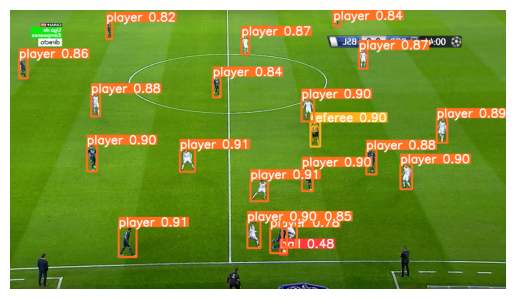

In [22]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
im_path = '/kaggle/working/yolov5/footballDetection/v8_ball_1280_243/10174.png'

image = Image.open(im_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()